<h1>Welcome to the Image Recognition Program!</h1>
<p>This program is designed to be easy to use, just execute each code block sequentially 
and read the comments for clarification.</p>

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os as os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.utils import plot_model
import tkinter as tk
from tkinter.filedialog import askopenfilename
import matplotlib.pyplot as plt

First, lets grab all of the images from our dataset.

All folder names will be assigned to items, which allows us to add extra folders for new item types if we so choose to in the future.

In [2]:
items = []
imageFolders = os.listdir('image')

for file in imageFolders:
    items.append(file)

<p>Here are some variables for the next couple of segments.</p>

In [3]:
batchSize = 32
imgWidth = 32
imgHeight = 32

<p>We will set the values for our training and validation models here.</p>

In [4]:
training = tf.keras.utils.image_dataset_from_directory(
    "image",
     validation_split = 0.2,
     subset = "training",
     seed = 1,
     image_size = (imgHeight, imgWidth),
     batch_size = batchSize,
     class_names = items
)

Found 17760 files belonging to 2 classes.
Using 14208 files for training.


In [5]:
validation = tf.keras.utils.image_dataset_from_directory(
    "image",
     validation_split = 0.2,
     subset = "validation",
     seed = 1,
     image_size = (imgHeight, imgWidth),
     batch_size = batchSize,
     class_names = items
)

Found 17760 files belonging to 2 classes.
Using 3552 files for validation.


In [6]:
classNames = training.class_names

<p>Data will be cached to keep it in memory, otherwise we would reload the data from disk whenever we run an epoch.</p>

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

training = training.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation = validation.cache().prefetch(buffer_size=AUTOTUNE)

<p>The model does not work well with large numbers, so if we are to use RGB for our images we must rescale the values to 0.0 - 1.0 instead of 0 - 255.</p>

In [8]:
normalizationLayer = layers.Rescaling(1./255)

<p>To prevent overfitting, our data will be augmented which will give more varaitions to our dataset.</p>

In [9]:
dataAugment = keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(imgHeight, imgWidth, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

<p>Here we will set the parameters for the model. Our model will have 3 convolutional layers, for the purpose of this project thhat results in a model that is accurate enough for our goal.</p>

In [10]:
numClasses = len(classNames)

model = Sequential([
  dataAugment,
  layers.Rescaling(1./255, input_shape=(imgHeight, imgWidth, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(numClasses)
])

<p>Now we will compile the model.</p>

In [11]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

<p>At last, we will now fit the model, it is ready for use.</p>

In [12]:
epochs = 5
history = model.fit(
  training,
  validation_data=validation,
  epochs=epochs
)

Epoch 1/5
444/444 [==============================] - 18s 26ms/step - loss: 0.2157 - accuracy: 0.9086 - val_loss: 0.1069 - val_accuracy: 0.9631
Epoch 2/5
444/444 [==============================] - 10s 23ms/step - loss: 0.0833 - accuracy: 0.9697 - val_loss: 0.0466 - val_accuracy: 0.9854
Epoch 3/5
444/444 [==============================] - 10s 23ms/step - loss: 0.0629 - accuracy: 0.9764 - val_loss: 0.0547 - val_accuracy: 0.9837
Epoch 4/5
444/444 [==============================] - 10s 23ms/step - loss: 0.0530 - accuracy: 0.9809 - val_loss: 0.0379 - val_accuracy: 0.9870
Epoch 5/5
444/444 [==============================] - 10s 23ms/step - loss: 0.0442 - accuracy: 0.9840 - val_loss: 0.0410 - val_accuracy: 0.9873


<p>Here are some charts that will give us some visual information on our model.</p>

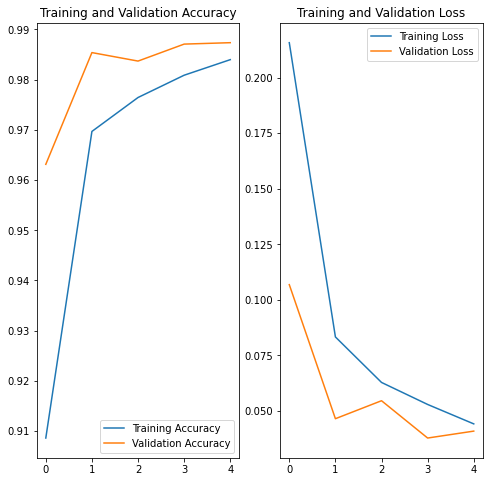

In [13]:
acc = history.history['accuracy']
valAcc = history.history['val_accuracy']

loss = history.history['loss']
valLoss = history.history['val_loss']

epochsNum = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochsNum, acc, label='Training Accuracy')
plt.plot(epochsNum, valAcc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochsNum, loss, label='Training Loss')
plt.plot(epochsNum, valLoss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

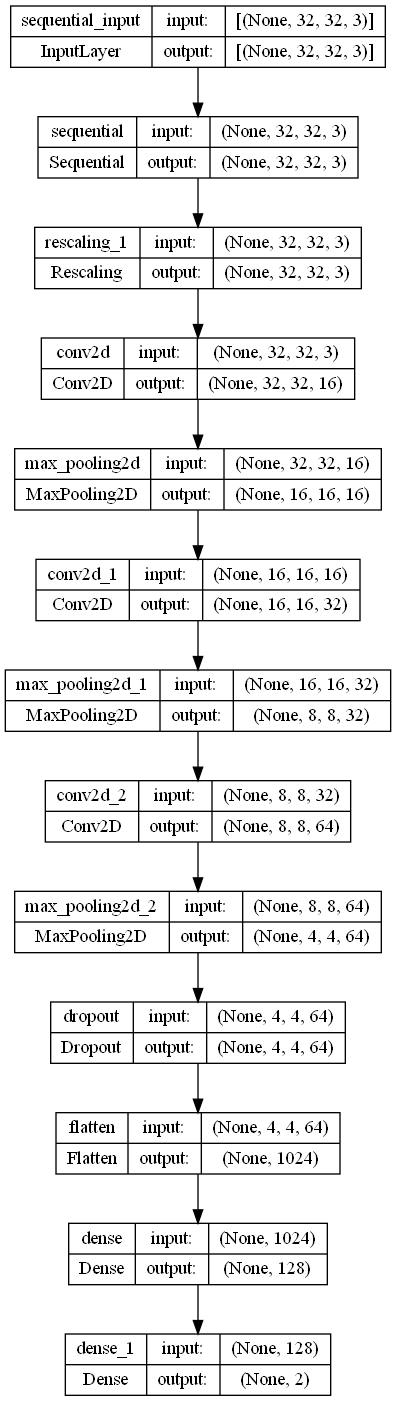

In [14]:
plot_model(model, to_file='cnnModel.png', show_shapes=True, show_layer_names=True)

<p>Now the user will be prompted to select an image for the regonition test. In this project, there is a folder named sample that has a few images that the user can use. Upon running this segment of code, the file explorer will open (they may need to minimize this window for it to appear). Simply select an image and the program will give you a result! A pie chart will show all of the models guesses. All images are provided by Wikipedia.</p>

<p>This section can be run multiple times by selecting it and pressing the run button. If you want to compare multiple images there is no need to run the entire model multiple times.</p>

1/1 [==============================] - 0s 166ms/step
This image is most likely a vehicles with a 99.99% confidence score.


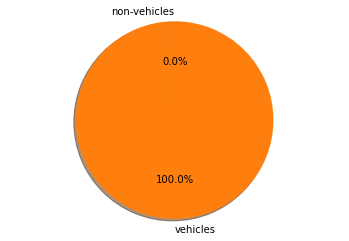

In [15]:
tk.Tk().withdraw()

fn = askopenfilename()

img = tf.keras.utils.load_img(fn, target_size=(32, 32))
imgArray = tf.keras.utils.img_to_array(img)
imgArray = tf.expand_dims(imgArray, 0)

prediction = model.predict(imgArray)
score = tf.nn.softmax(prediction[0])

print("This image is most likely a {} with a {:.2f}% confidence score."
     .format(classNames[np.argmax(score)], 100 * np.max(score)))

sizes = [score[0], score[1]]

fig, ax = plt.subplots()
ax.pie(sizes, labels = classNames, autopct='%1.1f%%',shadow=True, startangle=90)
ax.axis('equal')
plt.show()